In [1]:
!pip install -qU codecarbon
!pip install -qU onnx
!pip install -qU onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.7/516.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.4.0 requires httpx<1.0.0dev,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel,
    AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
)
import torch.nn as nn
import tensorflow as tf
from tqdm import tqdm
from codecarbon import EmissionsTracker
import onnx
import onnxruntime as ort
from sklearn.metrics import f1_score, precision_score, recall_score

In [3]:
arxiv_data = pd.read_csv('/content/arxiv_data.csv')
arxiv_data

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"
...,...,...,...
51766,Hierarchically-coupled hidden Markov models fo...,We address the problem of analyzing sets of no...,"['stat.ML', 'physics.bio-ph', 'q-bio.QM']"
51767,Blinking Molecule Tracking,We discuss a method for tracking individual mo...,"['cs.CV', 'cs.DM']"
51768,Towards a Mathematical Foundation of Immunolog...,We attempt to set a mathematical foundation of...,"['stat.ML', 'cs.LG', 'q-bio.GN']"
51769,A Semi-Automatic Graph-Based Approach for Dete...,Diffusion Tensor Imaging (DTI) allows estimati...,['cs.CV']


In [4]:
arxiv_data.shape

(51771, 3)

In [5]:
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print(labels)
print(len(labels))

['cs.CV' 'cs.LG' 'cs.AI' ... 'I.2.6; I.5.1; G.3'
 '92E10, 46M20, 94A08, 68U10, 44A12, 55R35' '92E10']
1099


In [6]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38970 rows in the deduplicated dataset.
2320
3156


In [7]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36650, 3)

In [8]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

In [9]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1832
Number of rows in test set: 1833


In [10]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.SE', 'cs.NI', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'cs.PL', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', 'quant-ph', 'math.DS', 'cs.CC', '68T05', 'physics.data-an', 'I.4.6', 'physics.soc-ph', 'physics.ao-ph', 'cs.DM', 'econ.EM', 'q-bio.GN', 'physics.med-ph', 'cs.PF', 'astro-ph.IM', 'I.4.8', 'math.AT', 'I.4', 'q-fin.TR', 'cs.FL', 'I.5.4', 'I.2', '68U10', 'physics.geo-ph', 'hep-ex', 'cond-mat.mtrl-sci', '68T10', 'physics.optics', 'physics.flu-dyn', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', 'I.2.10; I.4;

In [11]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG', 'cs.CV', 'stat.ML']
Label-binarized representation: [[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]]


In [12]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

,summaries
count,32985.000000
mean,156.419554
std,41.448674
min,1.000000
25%,128.000000
50%,154.000000
75%,183.000000
max,462.000000


In [13]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [14]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [15]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b"In this work, we introduce the Personalized Online Super Learner (POSL) -- an\nonline ensembling algorithm for streaming data whose optimization procedure\naccommodates varying degrees of personalization. Namely, POSL optimizes\npredictions with respect to baseline covariates, so personalization can vary\nfrom completely individualized (i.e., optimization with respect to baseline\ncovariate subject ID) to many individuals (i.e., optimization with respect to\ncommon baseline covariates). As an online algorithm, POSL learns in real-time.\nPOSL can leverage a diversity of candidate algorithms, including online\nalgorithms with different training and update times, fixed algorithms that are\nnever updated during the procedure, pooled algorithms that learn from many\nindividuals' time-series, and individualized algorithms that learn from within\na single time-series. POSL's ensembling of this hybrid of base learning\nstrategies depends on the amount of data collected, the station

In [16]:
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153410


In [17]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Hyperparameters
MAX_LEN = 150
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
MODEL_TYPES = ["bert-base-uncased", "distilbert-base-uncased", "google/bert_uncased_L-2_H-128_A-2"]
MODEL_NAMES = ["BERT", "DistilBERT", "TinyBERT"]

In [18]:
# Custom dataset class
class ArxivDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

In [19]:
# Model class
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(BERTClassifier, self).__init__()
        if 'distilbert' in model_name:
            self.bert = DistilBertModel.from_pretrained(model_name)
            self.dropout = nn.Dropout(0.1)
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        elif 'tinybert' in model_name:
            self.bert = AutoModel.from_pretrained(model_name)
            self.dropout = nn.Dropout(0.1)
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        else:
            self.bert = BertModel.from_pretrained(model_name)
            self.dropout = nn.Dropout(0.1)
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        if isinstance(self.bert, DistilBertModel):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0]
        else:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output

        x = self.dropout(pooled_output)
        logits = self.classifier(x)
        return logits

In [20]:
# Training function
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, device, model_save_path):
    best_val_loss = float('inf')
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}')

        for batch in train_progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{EPOCHS}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')

    return train_losses, val_losses

In [21]:
# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().detach().numpy()
            preds = (preds > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='micro')
    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')

    avg_loss = total_loss / len(dataloader)

    return {
        'loss': avg_loss,
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [22]:
def export_to_onnx(model, tokenizer, onnx_path):
    model.eval()
    device = next(model.parameters()).device  # Get the device the model is on

    # Create dummy input
    dummy_input = tokenizer(
        "This is a dummy input for ONNX export",
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = dummy_input['input_ids'].to(device)
    attention_mask = dummy_input['attention_mask'].to(device)

    # Export to ONNX using opset version 14 instead of 11
    torch.onnx.export(
        model,
        (input_ids, attention_mask),
        onnx_path,
        export_params=True,
        opset_version=14,  # Updated from 11 to 14
        do_constant_folding=True,
        input_names=['input_ids', 'attention_mask'],
        output_names=['output'],
        dynamic_axes={
            'input_ids': {0: 'batch_size'},
            'attention_mask': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )

    # Verify the ONNX model
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)

    print(f"Model successfully exported to {onnx_path}")

    return onnx_path

In [23]:
# Create label encoding mappings
def create_label_mappings(all_terms):
    # Flatten the list of lists
    all_terms_flat = []
    for terms in all_terms:
        all_terms_flat.extend(terms)

    # Get unique terms
    unique_terms = sorted(set(all_terms_flat))

    # Create mappings
    label2idx = {term: idx for idx, term in enumerate(unique_terms)}
    idx2label = {idx: term for term, idx in label2idx.items()}

    return label2idx, idx2label, len(unique_terms)

# Create one-hot encoded labels
def encode_labels(terms, label2idx):
    encoded = [0] * len(label2idx)
    for term in terms:
        if term in label2idx:
            encoded[label2idx[term]] = 1
    return encoded

label2idx, idx2label, num_labels = create_label_mappings(train_df['terms'].values)
print(f"Number of unique labels: {num_labels}")

Number of unique labels: 152


In [24]:
# Create emissions directory if it doesn't exist
if not os.path.exists("emissions"):
    os.makedirs("emissions")
    print("Created emissions directory")

Created emissions directory


In [25]:
# Run the entire training and evaluation pipeline
def run_pipeline(model_type, model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize tokenizer
    if 'distilbert' in model_type:
        tokenizer = DistilBertTokenizer.from_pretrained(model_type)
    elif 'tinybert' in model_type:
        tokenizer = AutoTokenizer.from_pretrained(model_type)
    else:
        tokenizer = BertTokenizer.from_pretrained(model_type)

    # Prepare datasets
    train_labels = [encode_labels(terms, label2idx) for terms in train_df['terms']]
    val_labels = [encode_labels(terms, label2idx) for terms in val_df['terms']]
    test_labels = [encode_labels(terms, label2idx) for terms in test_df['terms']]

    train_dataset = ArxivDataset(train_df['summaries'].values, train_labels, tokenizer, MAX_LEN)
    val_dataset = ArxivDataset(val_df['summaries'].values, val_labels, tokenizer, MAX_LEN)
    test_dataset = ArxivDataset(test_df['summaries'].values, test_labels, tokenizer, MAX_LEN)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Initialize model
    model = BERTClassifier(model_type, num_labels).to(device)

    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Track carbon emissions
    tracker = EmissionsTracker(project_name=f"{model_name}_training", output_dir="emissions")
    tracker.start()

    # Train model
    model_save_path = f"{model_name}_model.pt"
    train_losses, val_losses = train_model(
        model, train_dataloader, val_dataloader,
        optimizer, scheduler, device, model_save_path
    )

    # Stop tracking emissions
    emissions = tracker.stop()
    print(f"Carbon emissions: {emissions} kg CO2eq")

    # Load best model
    model.load_state_dict(torch.load(model_save_path))

    # Evaluate on test set
    test_metrics = evaluate_model(model, test_dataloader, device)
    print(f"Test metrics for {model_name}:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Export to ONNX
    onnx_path = f"{model_name}_model.onnx"
    export_to_onnx(model, tokenizer, onnx_path)

    return {
        'model_name': model_name,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_metrics': test_metrics,
        'emissions': emissions
    }

# Run the pipeline for each model type
results = []
for model_type, model_name in zip(MODEL_TYPES, MODEL_NAMES):
    print(f"\n{'='*50}")
    print(f"Training {model_name} model")
    print(f"{'='*50}\n")

    result = run_pipeline(model_type, model_name)
    results.append(result)


Training BERT model

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[codecarbon INFO @ 08:33:10] [setup] RAM Tracking...
[codecarbon INFO @ 08:33:10] [setup] CPU Tracking...
[codecarbon WARNING @ 08:33:10] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 08:33:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 08:33:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 08:33:11] [setup] GPU Tracking...
[codecarbon INFO @ 08:33:11] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:33:11] >>> Tracker's metad

Epoch 1/3:
Training Loss: 0.0924
Validation Loss: 0.0307
Model saved to BERT_model.pt


Epoch 2/3:   0%|          | 5/1031 [00:04<15:21,  1.11it/s, training_loss=0.032][codecarbon INFO @ 08:49:11] Energy consumed for RAM : 0.001267 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:49:11] Energy consumed for all CPUs : 0.011328 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:49:11] Energy consumed for all GPUs : 0.017789 kWh. Total GPU Power : 49.90976375066937 W
[codecarbon INFO @ 08:49:11] 0.030383 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:49:11] 0.004309 g.CO2eq/s mean an estimation of 135.89341230476904 kg.CO2eq/year
Epoch 2/3:   2%|▏         | 22/1031 [00:20<15:32,  1.08it/s, training_loss=0.034][codecarbon INFO @ 08:49:26] Energy consumed for RAM : 0.001286 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:49:26] Energy consumed for all CPUs : 0.011505 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:49:26] Energy consumed for all GPUs : 0.018068 kWh. Total GPU Power : 67.13361230856958 W
[codecarbon INFO @ 08:49:26] 

Epoch 2/3:
Training Loss: 0.0268
Validation Loss: 0.0235


[codecarbon INFO @ 09:04:56] Energy consumed for RAM : 0.002513 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:04:56] Energy consumed for all CPUs : 0.022477 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:04:56] Energy consumed for all GPUs : 0.035395 kWh. Total GPU Power : 64.27442854680503 W
[codecarbon INFO @ 09:04:56] 0.060386 kWh of electricity used since the beginning.


Model saved to BERT_model.pt


Epoch 3/3:   1%|          | 9/1031 [00:08<15:48,  1.08it/s, training_loss=0.027][codecarbon INFO @ 09:05:11] Energy consumed for RAM : 0.002533 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:05:11] Energy consumed for all CPUs : 0.022654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:05:11] Energy consumed for all GPUs : 0.035611 kWh. Total GPU Power : 51.798841424974924 W
[codecarbon INFO @ 09:05:11] 0.060799 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:05:11] 0.004313 g.CO2eq/s mean an estimation of 136.00335308399505 kg.CO2eq/year
Epoch 3/3:   3%|▎         | 26/1031 [00:23<15:15,  1.10it/s, training_loss=0.028][codecarbon INFO @ 09:05:26] Energy consumed for RAM : 0.002553 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:05:26] Energy consumed for all CPUs : 0.022832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:05:26] Energy consumed for all GPUs : 0.035892 kWh. Total GPU Power : 67.29962741644059 W
[codecarbon INFO @ 09:05:26]

Epoch 3/3:
Training Loss: 0.0233
Validation Loss: 0.0223


[codecarbon INFO @ 09:20:56] Energy consumed for RAM : 0.003780 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:20:56] Energy consumed for all CPUs : 0.033805 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:20:56] Energy consumed for all GPUs : 0.053196 kWh. Total GPU Power : 56.473178236699795 W
[codecarbon INFO @ 09:20:56] 0.090781 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:20:58] Energy consumed for RAM : 0.003782 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:20:58] Energy consumed for all CPUs : 0.033825 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:20:58] Energy consumed for all GPUs : 0.053212 kWh. Total GPU Power : 33.019508718577114 W
[codecarbon INFO @ 09:20:58] 0.090819 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:20:58] 0.004320 g.CO2eq/s mean an estimation of 136.24890939550878 kg.CO2eq/year


Model saved to BERT_model.pt
Carbon emissions: 0.012601151621050665 kg CO2eq


/usr/local/lib/python3.11/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
<ipython-input-25-236ca152aaf6>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects wil

Test metrics for BERT:
loss: 0.0223
accuracy: 0.9941
f1: 0.7349
precision: 0.8443
recall: 0.6506
Model successfully exported to BERT_model.onnx

Training DistilBERT model

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[codecarbon INFO @ 09:21:31] [setup] RAM Tracking...
[codecarbon INFO @ 09:21:31] [setup] CPU Tracking...
[codecarbon WARNING @ 09:21:31] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 09:21:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 09:21:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:21:32] [setup] GPU Tracking...
[codecarbon INFO @ 09:21:32] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:21:32] >>> Tracker's metad

Epoch 1/3:
Training Loss: 0.1049
Validation Loss: 0.0330


[codecarbon INFO @ 09:30:33] Energy consumed for RAM : 0.000712 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:30:33] Energy consumed for all CPUs : 0.006372 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:30:33] Energy consumed for all GPUs : 0.009716 kWh. Total GPU Power : 57.531956030432085 W
[codecarbon INFO @ 09:30:33] 0.016800 kWh of electricity used since the beginning.


Model saved to DistilBERT_model.pt


Epoch 2/3:   2%|▏         | 20/1031 [00:10<08:41,  1.94it/s, training_loss=0.035][codecarbon INFO @ 09:30:48] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:30:48] Energy consumed for all CPUs : 0.006549 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:30:48] Energy consumed for all GPUs : 0.009941 kWh. Total GPU Power : 53.831726336070886 W
[codecarbon INFO @ 09:30:48] 0.017222 kWh of electricity used since the beginning.
Epoch 2/3:   5%|▍         | 49/1031 [00:24<08:12,  2.00it/s, training_loss=0.035][codecarbon INFO @ 09:31:03] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:31:03] Energy consumed for all CPUs : 0.006725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:31:03] Energy consumed for all GPUs : 0.010212 kWh. Total GPU Power : 65.23527306664002 W
[codecarbon INFO @ 09:31:03] 0.017689 kWh of electricity used since the beginning.
Epoch 2/3:   8%|▊         | 78/1031 [00:39<07:5

Epoch 2/3:
Training Loss: 0.0282
Validation Loss: 0.0243
Model saved to DistilBERT_model.pt


Epoch 3/3:   2%|▏         | 21/1031 [00:10<08:33,  1.97it/s, training_loss=0.025][codecarbon INFO @ 09:39:48] Energy consumed for RAM : 0.001444 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:39:48] Energy consumed for all CPUs : 0.012920 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:39:48] Energy consumed for all GPUs : 0.019657 kWh. Total GPU Power : 62.002192715430475 W
[codecarbon INFO @ 09:39:48] 0.034022 kWh of electricity used since the beginning.
Epoch 3/3:   5%|▍         | 51/1031 [00:25<08:01,  2.04it/s, training_loss=0.027][codecarbon INFO @ 09:40:03] Energy consumed for RAM : 0.001464 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:40:03] Energy consumed for all CPUs : 0.013097 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:40:03] Energy consumed for all GPUs : 0.019931 kWh. Total GPU Power : 65.58701578252102 W
[codecarbon INFO @ 09:40:03] 0.034492 kWh of electricity used since the beginning.
Epoch 3/3:   8%|▊         | 81/1031 [00:41<07:4

Epoch 3/3:
Training Loss: 0.0239
Validation Loss: 0.0228


[codecarbon INFO @ 09:48:41] Energy consumed for RAM : 0.002148 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:48:41] Energy consumed for all CPUs : 0.019210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:48:41] Energy consumed for all GPUs : 0.029198 kWh. Total GPU Power : 37.395753053806004 W
[codecarbon INFO @ 09:48:41] 0.050556 kWh of electricity used since the beginning.
<ipython-input-25-236ca152aaf6>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mod

Model saved to DistilBERT_model.pt
Carbon emissions: 0.0070146052469547224 kg CO2eq


Evaluating: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


Test metrics for DistilBERT:
loss: 0.0229
accuracy: 0.9942
f1: 0.7379
precision: 0.8494
recall: 0.6523
Model successfully exported to DistilBERT_model.onnx

Training TinyBERT model

Using device: cuda


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[codecarbon INFO @ 09:49:00] [setup] RAM Tracking...
[codecarbon INFO @ 09:49:00] [setup] CPU Tracking...
[codecarbon WARNING @ 09:49:00] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 09:49:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 09:49:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:49:01] [setup] GPU Tracking...
[codecarbon INFO @ 09:49:01] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:49:01] >>> Tracker's metad

Epoch 1/3:
Training Loss: 0.3222
Validation Loss: 0.1442
Model saved to TinyBERT_model.pt


Epoch 2/3:   0%|          | 3/1031 [00:00<02:23,  7.16it/s, training_loss=0.151][codecarbon INFO @ 09:51:32] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:51:32] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:51:32] Energy consumed for all GPUs : 0.001388 kWh. Total GPU Power : 32.66941773206608 W
Epoch 2/3:  11%|█         | 114/1031 [00:15<01:56,  7.90it/s, training_loss=0.135][codecarbon INFO @ 09:51:47] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:51:47] Energy consumed for all CPUs : 0.001947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:51:47] Energy consumed for all GPUs : 0.001526 kWh. Total GPU Power : 33.19735211937662 W
[codecarbon INFO @ 09:51:47] 0.003691 kWh of electricity used since the beginning.
Epoch 2/3:  22%|██▏       | 224/1031 [00:30<01:54,  7.06it/s, training_loss=0.122][codecarbon INFO @ 09:52:02] Energy consumed for 

Epoch 2/3:
Training Loss: 0.1084
Validation Loss: 0.0828
Model saved to TinyBERT_model.pt


Epoch 3/3:   1%|          | 7/1031 [00:00<02:10,  7.85it/s, training_loss=0.084][codecarbon INFO @ 09:54:02] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:54:02] Energy consumed for all CPUs : 0.003539 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:02] Energy consumed for all GPUs : 0.002768 kWh. Total GPU Power : 32.51710438064368 W
[codecarbon INFO @ 09:54:02] 0.006703 kWh of electricity used since the beginning.
Epoch 3/3:  11%|█         | 110/1031 [00:16<02:15,  6.79it/s, training_loss=0.079][codecarbon INFO @ 09:54:17] Energy consumed for RAM : 0.000415 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:54:17] Energy consumed for all CPUs : 0.003717 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:17] Energy consumed for all GPUs : 0.002906 kWh. Total GPU Power : 33.166585881621586 W
[codecarbon INFO @ 09:54:17] 0.007038 kWh of electricity used since the beginning.
Epoch 3/3:  21%|██        | 218/1031 [00:30<01:

Epoch 3/3:
Training Loss: 0.0767
Validation Loss: 0.0708
Model saved to TinyBERT_model.pt
Carbon emissions: 0.0013928291282031013 kg CO2eq


Evaluating: 100%|██████████| 58/58 [00:06<00:00,  8.82it/s]


Test metrics for TinyBERT:
loss: 0.0711
accuracy: 0.9891
f1: 0.5756
precision: 0.5633
recall: 0.5885
Model successfully exported to TinyBERT_model.onnx


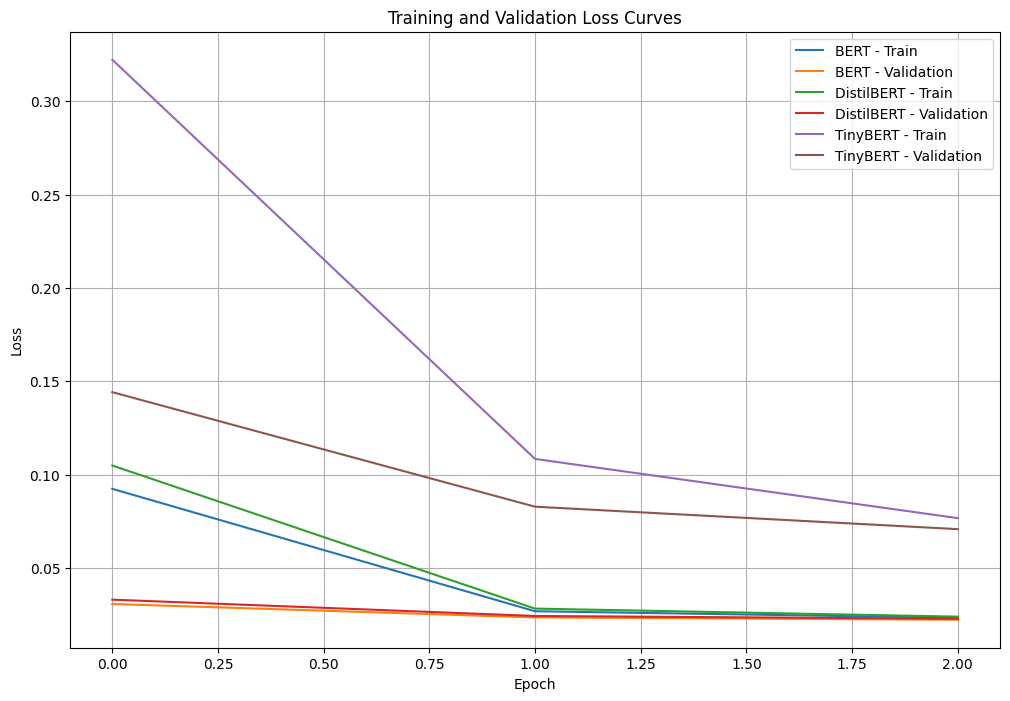

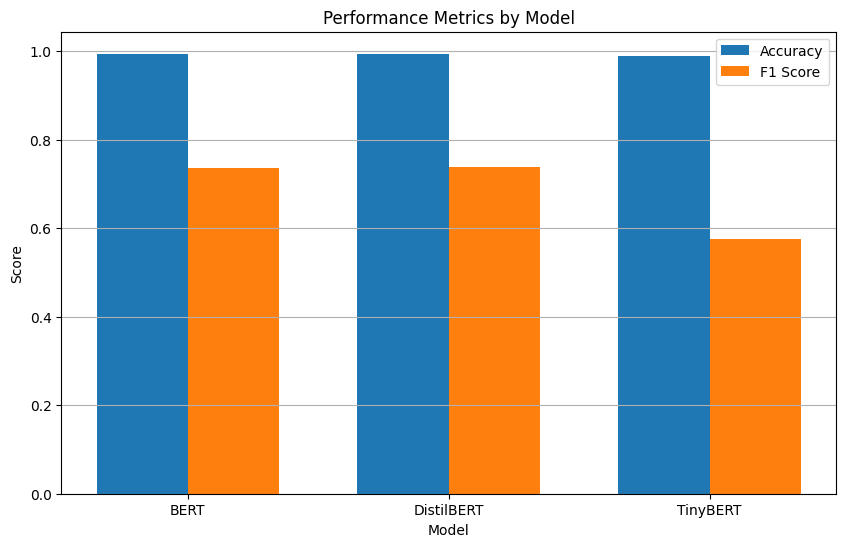

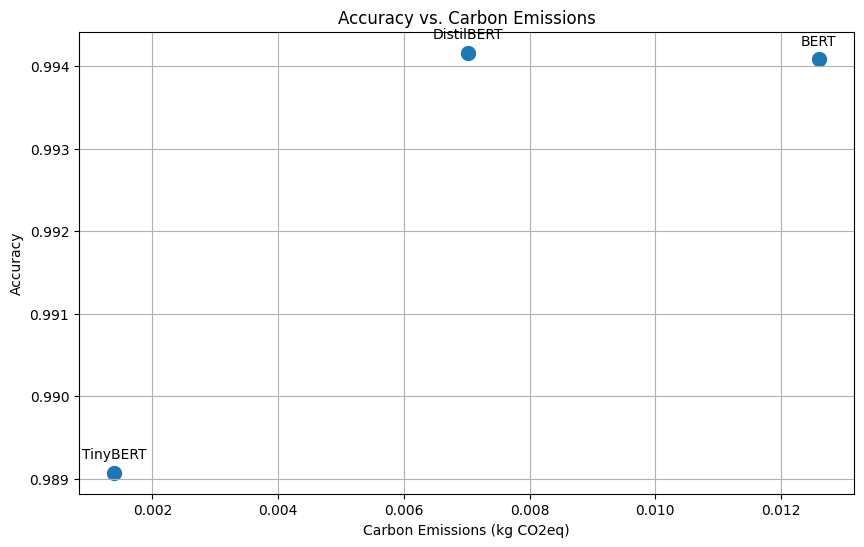

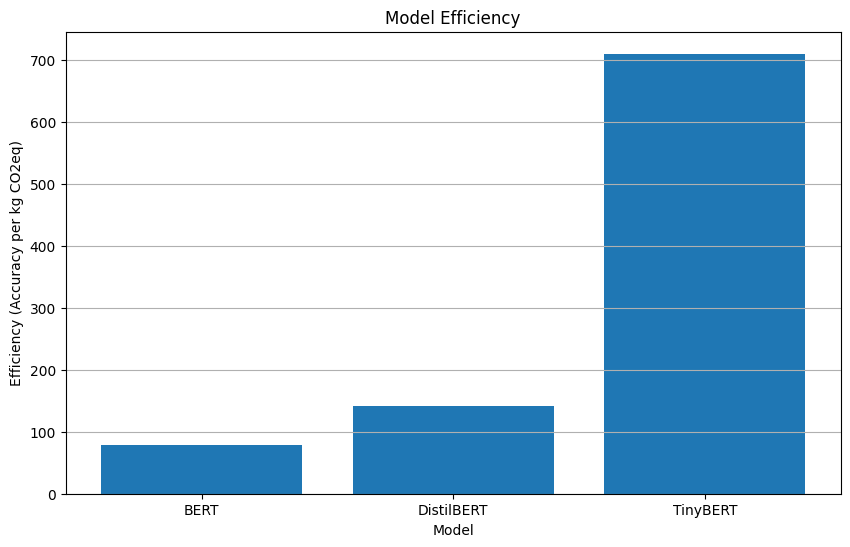

In [26]:
# Visualization functions
def plot_training_curves(results):
    plt.figure(figsize=(12, 8))

    for result in results:
        model_name = result['model_name']
        train_losses = result['train_losses']
        val_losses = result['val_losses']

        plt.plot(train_losses, label=f"{model_name} - Train")
        plt.plot(val_losses, label=f"{model_name} - Validation")

    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curves.png')
    plt.show()

def plot_model_comparison(results):
    model_names = [result['model_name'] for result in results]
    accuracies = [result['test_metrics']['accuracy'] for result in results]
    f1_scores = [result['test_metrics']['f1'] for result in results]
    emissions = [result['emissions'] for result in results]

    # Metrics comparison
    plt.figure(figsize=(10, 6))
    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width/2, accuracies, width, label='Accuracy')
    plt.bar(x + width/2, f1_scores, width, label='F1 Score')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Performance Metrics by Model')
    plt.xticks(x, model_names)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('performance_comparison.png')
    plt.show()

    # Accuracy vs Emissions
    plt.figure(figsize=(10, 6))
    plt.scatter(emissions, accuracies, s=100)

    for i, model_name in enumerate(model_names):
        plt.annotate(model_name, (emissions[i], accuracies[i]),
                    textcoords="offset points", xytext=(0,10), ha='center')

    plt.xlabel('Carbon Emissions (kg CO2eq)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Carbon Emissions')
    plt.grid(True)
    plt.savefig('accuracy_vs_emissions.png')
    plt.show()

    # Efficiency metric (accuracy per emission)
    efficiency = [acc/em for acc, em in zip(accuracies, emissions)]

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, efficiency)
    plt.xlabel('Model')
    plt.ylabel('Efficiency (Accuracy per kg CO2eq)')
    plt.title('Model Efficiency')
    plt.grid(True, axis='y')
    plt.savefig('model_efficiency.png')
    plt.show()

# Generate visualizations
plot_training_curves(results)
plot_model_comparison(results)

In [27]:
# Function to perform inference with the ONNX model
def onnx_inference(onnx_path, tokenizer, text, label2idx, idx2label):
    # Create an ONNX Runtime session
    session = ort.InferenceSession(onnx_path)

    # Tokenize the input text
    inputs = tokenizer(
        text,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Get input names
    input_names = [input.name for input in session.get_inputs()]

    # Create the input feed
    ort_inputs = {
        input_names[0]: inputs['input_ids'].numpy(),
        input_names[1]: inputs['attention_mask'].numpy()
    }

    # Run inference
    outputs = session.run(None, ort_inputs)

    # Process outputs
    logits = outputs[0]
    predictions = (1 / (1 + np.exp(-logits))) > 0.5

    # Get predicted labels
    predicted_labels = []
    for idx, pred in enumerate(predictions[0]):
        if pred:
            predicted_labels.append(idx2label[idx])

    return predicted_labels

# Example of using the ONNX model for inference
example_text = test_df['summaries'].iloc[0]
onnx_path = f"{MODEL_NAMES[0]}_model.onnx"  # Using the BERT model for example
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPES[0])

print("\nExample text for inference:")
print(example_text)

print("\nActual labels:")
print(test_df['terms'].iloc[0])

print("\nPredicted labels (ONNX model):")
predicted_labels = onnx_inference(onnx_path, tokenizer, example_text, label2idx, idx2label)
print(predicted_labels)

# Summary report
print("\n" + "="*80)
print("SUMMARY REPORT")
print("="*80)

print("\nModel Performance:")
for result in results:
    model_name = result['model_name']
    metrics = result['test_metrics']
    emissions = result['emissions']

    print(f"\n{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  Carbon Emissions: {emissions:.6f} kg CO2eq")
    print(f"  Efficiency (Accuracy/Emissions): {metrics['accuracy']/emissions:.6f}")

# Find the most efficient model
efficiency_scores = [result['test_metrics']['accuracy']/result['emissions'] for result in results]
most_efficient_idx = efficiency_scores.index(max(efficiency_scores))
most_accurate_idx = [result['test_metrics']['accuracy'] for result in results].index(
    max([result['test_metrics']['accuracy'] for result in results])
)

print("\nRecommendation:")
print(f"Most Accurate Model: {results[most_accurate_idx]['model_name']}")
print(f"Most Efficient Model: {results[most_efficient_idx]['model_name']}")

if most_efficient_idx != most_accurate_idx:
    acc_diff = results[most_accurate_idx]['test_metrics']['accuracy'] - results[most_efficient_idx]['test_metrics']['accuracy']
    emission_diff = results[most_accurate_idx]['emissions'] - results[most_efficient_idx]['emissions']

    print(f"\nBy choosing {results[most_efficient_idx]['model_name']} over {results[most_accurate_idx]['model_name']}:")
    print(f"  Accuracy trade-off: {acc_diff:.4f} ({acc_diff*100:.2f}%)")
    print(f"  Emission reduction: {emission_diff:.6f} kg CO2eq ({emission_diff/results[most_accurate_idx]['emissions']*100:.2f}%)")


Example text for inference:
Recently image-to-image translation has attracted significant interests in
the literature, starting from the successful use of the generative adversarial
network (GAN), to the introduction of cyclic constraint, to extensions to
multiple domains. However, in existing approaches, there is no guarantee that
the mapping between two image domains is unique or one-to-one. Here we propose
a self-inverse network learning approach for unpaired image-to-image
translation. Building on top of CycleGAN, we learn a self-inverse function by
simply augmenting the training samples by swapping inputs and outputs during
training and with separated cycle consistency loss for each mapping direction.
The outcome of such learning is a proven one-to-one mapping function. Our
extensive experiments on a variety of datasets, including cross-modal medical
image synthesis, object transfiguration, and semantic labeling, consistently
demonstrate clear improvement over the CycleGAN method